In [3]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# Initial look

The goal of this notebook is just to do an initial characterization of structural variants that are in the vicinity of EWSR1 and FLI1. We'll do the actual implementation of whatever framework we decide to use elsewhere, this is just to get acquainted with the formatting and layouts of SVs.

# More on the EWSR1-FLI1 fusion

Central to this endeavor will be identifying the location of the EWSR1-FLI1 fusion. A little more on these genes specifically:

__EWSR1 (chr22:29268268-29300521)__

This gene "acts in various cellular processes, including gene expression, cell signaling, and RNA processing and transport. The protein includes an N-terminal transcriptional activation domain and a C-terminal RNA-binding domain."

EWSR1 has 17 exons and spans 32kb (656 AA). There are at least three isoforms that have been described--a full length, one with a minor (1 AA) C terminal difference, and one that lacks exon 6.

__FLI1 (chr11:128694072-128813267)__

FLI1 is a transcription factor that contains ETS DNA-binding domain. It is the portion of the fusion that is responsible for the transcriptional derangement in Ewing's. FLI1 is quite large, with 9 exons and spanning 119kb (452 AA). There are a handful of isoforms, mostly those that lack exon 4.

## So where is the fusion?

I've spent some time looking at prior studies that characterized this fusion to find the exact breakpoints, and here are a few studies that I've found:

- https://pubmed.ncbi.nlm.nih.gov/25223734/  
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC413872/ (an old study from 1993 that used restriction enzymes to map the fusion)  
- Riaz's personal cohort.

In [4]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [5]:
# EWSR1-203 and FLI1-205 are the full length transcripts (they have tons of splice variants)
gene_gtfs = {}
gene_attrs = {"EWSR1": "EWSR1-203", "FLI1": "FLI1-205"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf

In [6]:
gene_gtfs["EWSR1"]["feature"].value_counts()

exon           17
CDS            17
UTR             2
transcript      1
start_codon     1
stop_codon      1
Name: feature, dtype: int64

## Load the fusion breakpoint data

We'll be focusing on Riaz's data and the other WGS paper. These are almost certainly hg19, so we'll need to liftover.

In [7]:
riaz_data = pd.read_csv(
    "data/fusion-breakpoints/aews18b1_ewings_fusion_breakpoint_info_4_6_23.txt",
    sep="\t",
)

# some reformatting, and remove the chr prefix
riaz_fusions = riaz_data[riaz_data["Fusion"].str.contains("EWS|FLI")].copy()
riaz_fusions[["left", "right"]] = riaz_fusions["Fusion breakpoint notation"].str.split(
    "::", expand=True
)
riaz_fusions[["left", "right"]] = riaz_fusions[["left", "right"]].applymap(
    lambda bp: bp[3:]
)

# extract the SVs identified in Delattre 2014
delattre_data = pd.read_excel(
    "data/fusion-breakpoints/NIHMS628157-supplement-4.xlsx",
    sheet_name="Table S2c_SV",
    skiprows=2,
)
delattre_fusions = delattre_data[
    (delattre_data["GeneA"].str.contains("EWSR1|FLI1"))
    & (delattre_data["GeneB"].str.contains("EWSR1|FLI1"))
].copy()
delattre_fusions["left"] = (
    delattre_fusions["#chrA"].astype(str) + ":" + delattre_fusions["posA"].astype(str)
)
delattre_fusions["right"] = (
    delattre_fusions["chrB"].astype(str) + ":" + delattre_fusions["posB"].astype(str)
)

# now we do some reformatting and combine, just for the breakpoints
fusion_bps = pd.concat(
    [riaz_fusions[["left", "right"]], delattre_fusions[["left", "right"]]]
).reset_index(drop=True)

# do the liftover
hg19_to_hg38 = get_lifter("hg19", "hg38")


def liftover(bp, converter):
    contig, loc = bp.split(":")
    res = converter.query(contig, int(loc))
    return f"{res[0][0][3:]}:{res[0][1]}"


fusion_bps["left-hg38"] = fusion_bps["left"].apply(
    lambda bp: liftover(bp, hg19_to_hg38)
)
fusion_bps["right-hg38"] = fusion_bps["right"].apply(
    lambda bp: liftover(bp, hg19_to_hg38)
)

fusion_bps.head()

,left,right,left-hg38,right-hg38
0,22:29688661,11:128644198,22:29292672,11:128774303
1,22:29688506,11:128663536,22:29292517,11:128793641
2,22:29688505,11:128675650,22:29292516,11:128805755
3,22:29688473,11:128676327,22:29292484,11:128806432
4,22:29688453,11:128649624,22:29292464,11:128779729


## Mapping the fusion breakpoints

We'll plot out these genes and denote where the breakpoints happen.

In [8]:
genes = {
    "EWSR1": ["chr22", 29267009, 29301522],
    "FLI1": ["chr11", 128693072, 128814267],
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

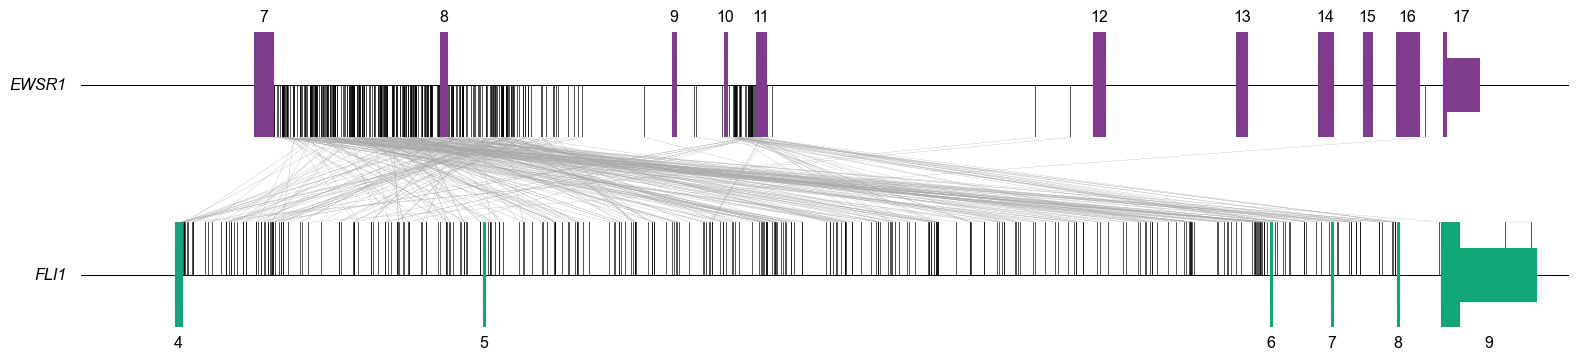

In [9]:
windows = {"EWSR1": [29285000, 29301522], "FLI1": [128770000, 128814267]}

fig, axes = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={"hspace": 0.8})

for i, g in enumerate(["EWSR1", "FLI1"]):

    ax = axes[i]
    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
    label = "top" if g == "EWSR1" else "bottom"
    ax = sv_plot.plot_genomic_elements(
        ax, g_gtf, window=windows[g], feature_colors=feature_colors, label=label
    )
    aesthetics.strip_axis(ax=ax, x="label")
    ax.set_xticklabels([])
    ax.set_xlim(windows[g])

    ax.text(
        x=-0.01,
        y=0.5,
        s=g,
        fontstyle="italic",
        transform=ax.transAxes,
        ha="right",
        va="center",
    )

# next we add in the breakpoints
for index, row in fusion_bps.iterrows():
    left, right = row[["left-hg38", "right-hg38"]].values

    fig_x, fig_y = [], []
    for bp in [left, right]:
        contig, loc = bp.split(":")
        loc = int(loc)

        if contig == "22":
            ax = axes[0]
            ax.plot([loc, loc], [-1, 0], color="black", linewidth=0.5)
            data_point = [loc, -1]

        elif contig == "11":
            ax = axes[1]
            ax.plot([loc, loc], [0, 1], color="black", linewidth=0.5)
            data_point = [loc, 1]

        # exclude some fusions that are outside our range
        if (contig == "22" and loc < 29285000) or (contig == "11" and loc < 128770000):
            continue

        # get our figure point
        fig_point = fig.transFigure.inverted().transform(
            ax.transData.transform(data_point)
        )
        fig_x.append(fig_point[0])
        fig_y.append(fig_point[1])

    # add the connecting line
    fig.add_artist(Line2D(fig_x, fig_y, color="darkgrey", zorder=1, linewidth=0.2))

fig.savefig("images/ewsr1-fli1-fusion-locations.png")

So we see that there is some degree of heterogeneity, but the majority of fusions involve intronic regions between exons 7 and 8 in EWSR1 and exons 5 and 6 in FLI1. This is consistent with what's known.

# Start looking at SVs around these genes

We're essentially just going to repeat this process, just to visualize. We load both the SVs and the dosage matrix. Note that we'll use the "validation" cohort, because that increasingly looks like we'll use that for discovery.

In [10]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/archive/v1.1/PedSV.v1.1.validation_cohort.analysis_samples.wAFs.bed.gz",
    sep="\t",
)
dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/archive/v1.1/PedSV.v1.1.validation_cohort.analysis_samples.wAFs.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (19,20,21,23,25,27,31,32,33,34,48,49,63,64,82,83,89,98,99,113,114,132,133,138,147,148,162,163,181,182,187,196,197,211,212,230,231,245,246,260,261,279,280,285,294,295,309,310,328,329,336,345,346,351,360,361,375,376,381,390,391,398,407,408,413,422,423,428,437,438,443,452,453,460,469,470,475,484,485,490,499,500,505,514,515,522,531,532,537,546,547,552,561,562,567,576,577,584,593,594,599,608,609,623,624,629,638,639,646,655,656,661,670,671,676,685,686,700,701,707,713,719,725,731) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
svs['svtype'].value_counts()

DEL             126469
DUP              46118
BND              40753
INS:ME:ALU       32310
INS              11625
INS:ME:LINE1      4892
INS:ME:SVA        3211
CPX               2878
CNV               1084
INS:ME             475
INV                292
CTX                  6
Name: svtype, dtype: int64

We now get our sample level data. For this analysis, we focus on Ewing's and the Ewing's controls.

In [13]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/archive/gatk_sv_pediatric_cancers_combined_cohort_metadata_3_31_23.w_control_assignments.txt",
    sep="\t",
)
validation_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/af_annotation_files/PedSV.v1.validation_cohort_final_samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
ewings_samples = metadata[metadata["disease"] == "ewing"]["entity:sample_id"].to_list()
ewings_samples = sorted(set(validation_samples) & set(ewings_samples))

control_samples = metadata[metadata["ewing_control"]]["entity:sample_id"].to_list()
control_samples = sorted(set(validation_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(ewings_samples), len(control_samples)

(580, 2019)

We begin by identifying structural variants that fall within our regions of interest. We only include SVs that pass quality filters (for now). We expand our search space to 1 Mb outside of these genes.

There are some small peculiarities that we should consider. Namely:
* SVs that span a region are included if any part of there region is 1 Mb away
* Complex SVs are included if any component SV is in the region


In [14]:
# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [15]:
svs_in_regions.head(2)

,chrom,start,end,name,gene
0,chr11,128214384,128216760,All_20_Batches.chr11.final_cleanup_DEL_chr11_6406,FLI1
1,chr11,128214734,128214799,All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,FLI1


In [16]:
svs_in_regions.shape

(180, 5)

So it looks like there's a handful of SVs in this region. But this was only based on `Start` and `End`. There are complex SVs that may involve more. 

Most complex SVs would have already been caught above, as most are intrachromosomal and handled nicely by GATK. This code is only for theoretical interchromosomal events, but I cover them for completeness.

In [17]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [18]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr22,29729402,29729577,All_20_Batches.chr5.final_cleanup_CPX_chr5_79,EWSR1


In [19]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(1, 0)

So looks like 1 SV was missed in our initial simple overlap. It's pretty obvious why this is the case:

In [20]:
svs[svs["name"].isin(complex_svs_in_regions["name"])].head(1)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,HIGH_SR_BACKGROUND,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SOURCE,STRANDS,SVLEN,SVTYPE,UNRESOLVED_TYPE,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,...,SAS_neuroblastoma_CN_NUMBER,SAS_neuroblastoma_CN_COUNT,SAS_neuroblastoma_CN_FREQ,SAS_neuroblastoma_CN_NONDIPLOID_COUNT,SAS_neuroblastoma_CN_NONDIPLOID_FREQ,SAS_osteosarcoma_AN,SAS_osteosarcoma_AC,SAS_osteosarcoma_AF,SAS_osteosarcoma_N_BI_GENOS,SAS_osteosarcoma_N_HOMREF,SAS_osteosarcoma_N_HET,SAS_osteosarcoma_N_HOMALT,SAS_osteosarcoma_FREQ_HOMREF,SAS_osteosarcoma_FREQ_HET,SAS_osteosarcoma_FREQ_HOMALT,SAS_osteosarcoma_CN_NUMBER,SAS_osteosarcoma_CN_COUNT,SAS_osteosarcoma_CN_FREQ,SAS_osteosarcoma_CN_NONDIPLOID_COUNT,SAS_osteosarcoma_CN_NONDIPLOID_FREQ,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONDIPLOID_FREQ,POPMAX_control_AF,POPMAX_control_FREQ_HOMREF,POPMAX_control_FREQ_HET,POPMAX_control_FREQ_HOMALT,POPMAX_control_CN_FREQ,POPMAX_control_CN_NONDIPLOID_FREQ,POPMAX_ewing_AF,POPMAX_ewing_FREQ_HOMREF,POPMAX_ewing_FREQ_HET,POPMAX_ewing_FREQ_HOMALT,POPMAX_ewing_CN_FREQ,POPMAX_ewing_CN_NONDIPLOID_FREQ,POPMAX_neuroblastoma_AF,POPMAX_neuroblastoma_FREQ_HOMREF,POPMAX_neuroblastoma_FREQ_HET,POPMAX_neuroblastoma_FREQ_HOMALT,POPMAX_neuroblastoma_CN_FREQ,POPMAX_neuroblastoma_CN_NONDIPLOID_FREQ,POPMAX_osteosarcoma_AF,POPMAX_osteosarcoma_FREQ_HOMREF,POPMAX_osteosarcoma_FREQ_HET,POPMAX_osteosarcoma_FREQ_HOMALT,POPMAX_osteosarcoma_CN_FREQ,POPMAX_osteosarcoma_CN_NONDIPLOID_FREQ,FILTER
82419,chr5,31244570,31244572,All_20_Batches.chr5.final_cleanup_CPX_chr5_79,CPX,5,0.000698,manta,7162,True,chr22,DUP_chr22:29729402-29729577,dDUP,31244572,31244572.0,"PE,SR",False,0.0,False,NaN,NaN,NaN,False,CABP7,CDH6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUP_chr22:29729402-29729577,NaN,175,CPX,NaN,3581.0,3576.0,5.0,0.0,0.998604,0.001396,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.016667,0.0,NaN,NaN,0.008108,1.0,0.016216,0.0,NaN,NaN,0.035714,1.0,0.071429,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.010638,1.0,0.021277,0.0,NaN,NaN,PASS


We can see why this was missed - it's a dispersed duplication where a region of chromosome 5 (?) was inserted into a region of chromosome 22.

In any case, we can now generate a (preliminary) list of SVs that are within 1 Mb of EWSR1 or FLI1.

## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [21]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

In [22]:
len(svs_in_regions_names)

181

So a decent number of SVs in this dataset fall within this region. Briefly, Ryan and Riaz wanted to know if there are any MCNVs


In [23]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL             94
DUP             31
INS:ME:ALU      31
BND             13
INS              4
INS:ME:LINE1     3
INS:ME:SVA       3
CPX              1
CTX              1
Name: svtype, dtype: int64

So no. We fetch all these SVs from the original dataset now and apply some filters:

In [24]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS                         155
UNRESOLVED                    13
HIGH_PCRMINUS_NOCALL_RATE     13
Name: FILTER, dtype: int64

Rare:
 True     149
False     32
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

We'll add in a quick QC method to remove some suspect SVs that Ryan is concerned about.

In [25]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
        & (~subset_svs["EVIDENCE"].isin(["BAF,RD", "RD"]))
        & (~(subset_svs["ALGORITHMS"] == "depth"))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(148, 736)

In [26]:
svs_to_keep["svtype"].value_counts()

DEL             78
INS:ME:ALU      31
DUP             27
INS              4
INS:ME:LINE1     3
INS:ME:SVA       3
CTX              1
CPX              1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

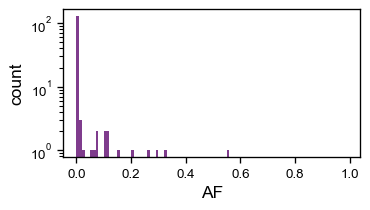

In [27]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

In [28]:
(svs_to_keep["AF"] < 0.01).value_counts()

True     130
False     18
Name: AF, dtype: int64

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [29]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_2AHXQP58,PT_GMGNDRBJ,PT_MEC48DAY,PT_N8PKC3YS,PT_VEMC27RN,SJ051090,SJ051119,SJ051140,SJ051197,SJ051210,SJ051231,SJ051244,SJ051246,SJ051259,SJ051263,SJ051267,SJ051298,SJ051299,SJ051310,SJ051322,SJ051329,SJ051336,SJ051367,SJ051390,SJ051391,SJ051392,SJ051416,SJ051439,SJ051485,SJ051531,SJ051539,SJ051566,SJ051574,SJ051610,SJ051653,SJ051655,SJ051662,SJ051672,SJ051679,SJ051694,SJ051705,SJ051713,...,SJ054333,SJ055976,SJ055977,SJ055980,SJ055992,SJ056005,SJ056011,SJ056035,SJ056044,SJ056062,SJ056068,SJ056156,SJ056241,SJ056250,SJ056312,SJ056317,SJ056321,SJ056360,SJ056374,SJ056381,SJ056446,SJ056468,SJ056480,SJ056503,SJ056509,SJ056535,SJ056833,SJ056855,SJ056862,SJ056888,SJ056891,SJ056916,SJ056922,SJ056924,SJ058208,SJ058211,SJ058213,SJ058220,SJ058227,SJ058233,SJ058237,SJ058252,SJ058253,SJ058283,SJ063819,SJ063829,SJ063834,SJ071780,SJ071781,ssi_11896
1,All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,FLI1,0.002793,True,chr11,128214735,128214799,All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,FLI1,0.320581,False,chr11,128226922,128226985,All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [30]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [ewings_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [31]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint
0,All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,FLI1,chr11,128214735,128214799,0.002793,True,578,2,0,2014,5,0,128214767.0
1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,FLI1,chr11,128226922,128226985,0.320581,False,223,301,56,885,945,189,128226953.5


Next we add some columns for allele frequency.

In [32]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [33]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,FLI1,chr11,128214735,128214799,0.002793,True,578,2,0,2014,5,0,128214767.0,0.001724,0.001238
1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,FLI1,chr11,128226922,128226985,0.320581,False,223,301,56,885,945,189,128226953.5,0.356034,0.327637


In [34]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare
gene,,,,
EWSR1,0.994828,0.081034,0.998019,0.103021
FLI1,0.960345,0.070690,0.958395,0.079742


Interesting--unless I've made a mistake, the controls have more rare SVs around these genes than controls.

Any smoking guns in terms of SVs?

In [35]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
37,All_20_Batches.chr11.final_cleanup_DEL_chr11_6436,FLI1,chr11,128930551,128930727,0.206925,False,320,258,2,1250,768,1,128930639.0,0.225862,0.190688
1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,FLI1,chr11,128226922,128226985,0.320581,False,223,301,56,885,945,189,128226953.5,0.356034,0.327637
35,All_20_Batches.chr11.final_cleanup_DUP_chr11_2410,FLI1,chr11,128930541,128930890,0.073931,False,476,86,0,1762,219,0,128930715.5,0.076512,0.055275
36,All_20_Batches.chr11.final_cleanup_DUP_chr11_2411,FLI1,chr11,128930541,128930680,0.009248,True,526,18,0,1887,24,0,128930610.5,0.016544,0.006279


In [36]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
46,All_20_Batches.chr11.final_cleanup_DUP_chr11_2414,FLI1,chr11,129062906,129063032,0.077632,False,504,69,7,1739,224,56,129062969.0,0.071552,0.083210
69,All_20_Batches.chr22.final_cleanup_DEL_chr22_1086,EWSR1,chr22,28781357,28781650,0.558782,False,5,524,51,9,1760,250,28781503.5,0.539655,0.559683
115,All_20_Batches.chr22.final_cleanup_DUP_chr22_557,EWSR1,chr22,29410573,29410660,0.118263,False,466,114,0,1427,591,1,29410616.5,0.098276,0.146855
54,All_20_Batches.chr11.final_cleanup_DUP_chr11_2415,FLI1,chr11,129143072,129145383,0.269617,False,358,208,14,897,980,142,129144227.5,0.203448,0.313026


I find that somewhat surprising... there are several instances where the number of SVs in a gene is different between cases and controls, but it seems to favor the controls. What could be the reason for this, ancestry? Artifact?

## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


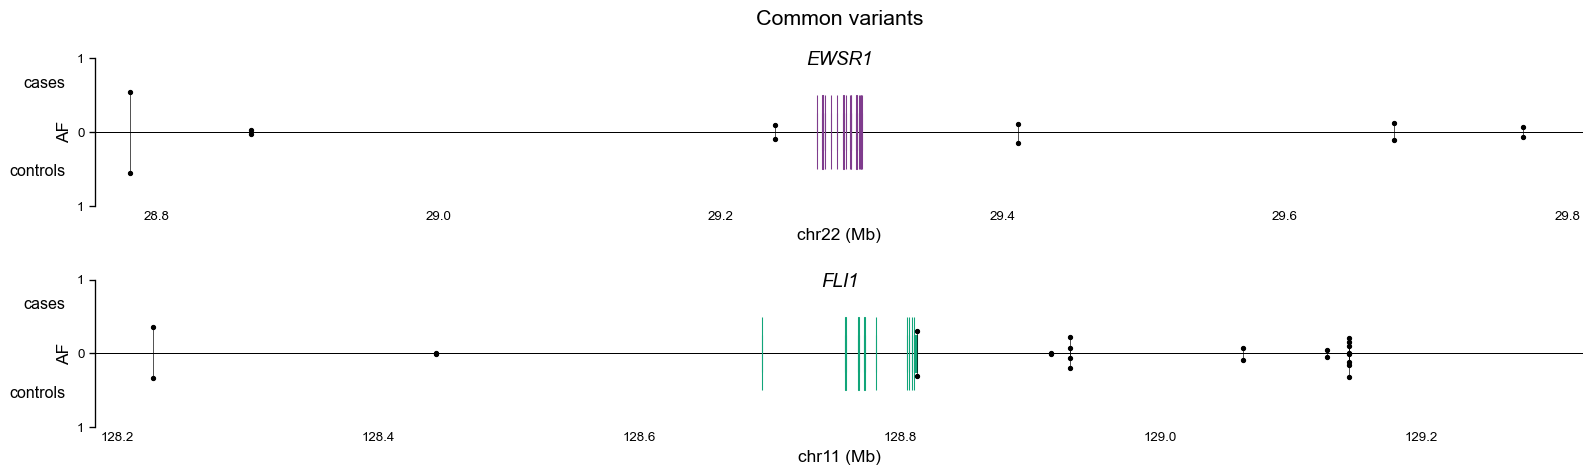

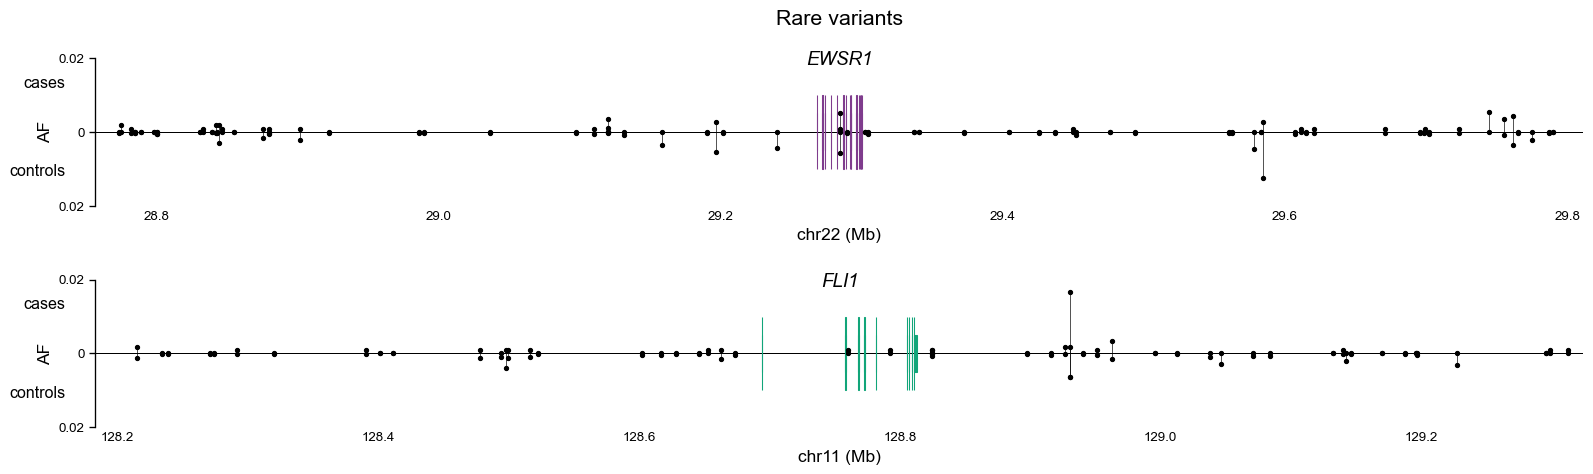

In [37]:
for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.9)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene]

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    fig.savefig(f"images/{plot}.png")

In [40]:
case_control_sv_counts.query('gene == "EWSR1" & rare == False').sort_values(by = 'start')

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
69,All_20_Batches.chr22.final_cleanup_DEL_chr22_1086,EWSR1,chr22,28781357,28781650,0.558782,False,5,524,51,9,1760,250,28781503.5,0.539655,0.559683
84,All_20_Batches.chr22.final_cleanup_DEL_chr22_1098,EWSR1,chr22,28867156,28867236,0.026669,False,557,23,0,1915,104,0,28867196.0,0.019828,0.025755
104,All_20_Batches.chr22.final_cleanup_DEL_chr22_1113,EWSR1,chr22,29237100,29239401,0.108659,False,480,89,11,1682,276,61,29238250.5,0.095690,0.098564
115,All_20_Batches.chr22.final_cleanup_DUP_chr22_557,EWSR1,chr22,29410573,29410660,0.118263,False,466,114,0,1427,591,1,29410616.5,0.098276,0.146855
132,All_20_Batches.chr22.final_cleanup_DUP_chr22_565,EWSR1,chr22,29676948,29677008,0.110304,False,458,107,15,1615,355,49,29676978.0,0.118103,0.112184
142,All_20_Batches.chr22.final_cleanup_DEL_chr22_1146,EWSR1,chr22,29767441,29769676,0.066601,False,514,65,1,1746,268,5,29768558.5,0.057759,0.068846


In [46]:
svs[(svs['svtype'] == "INS") & (svs['#chrom'] == "chr22") & (svs['AF'] > 0.20) & (svs['start'] > 29000000)]

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,HIGH_SR_BACKGROUND,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SOURCE,STRANDS,SVLEN,SVTYPE,UNRESOLVED_TYPE,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,...,SAS_neuroblastoma_CN_NUMBER,SAS_neuroblastoma_CN_COUNT,SAS_neuroblastoma_CN_FREQ,SAS_neuroblastoma_CN_NONDIPLOID_COUNT,SAS_neuroblastoma_CN_NONDIPLOID_FREQ,SAS_osteosarcoma_AN,SAS_osteosarcoma_AC,SAS_osteosarcoma_AF,SAS_osteosarcoma_N_BI_GENOS,SAS_osteosarcoma_N_HOMREF,SAS_osteosarcoma_N_HET,SAS_osteosarcoma_N_HOMALT,SAS_osteosarcoma_FREQ_HOMREF,SAS_osteosarcoma_FREQ_HET,SAS_osteosarcoma_FREQ_HOMALT,SAS_osteosarcoma_CN_NUMBER,SAS_osteosarcoma_CN_COUNT,SAS_osteosarcoma_CN_FREQ,SAS_osteosarcoma_CN_NONDIPLOID_COUNT,SAS_osteosarcoma_CN_NONDIPLOID_FREQ,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONDIPLOID_FREQ,POPMAX_control_AF,POPMAX_control_FREQ_HOMREF,POPMAX_control_FREQ_HET,POPMAX_control_FREQ_HOMALT,POPMAX_control_CN_FREQ,POPMAX_control_CN_NONDIPLOID_FREQ,POPMAX_ewing_AF,POPMAX_ewing_FREQ_HOMREF,POPMAX_ewing_FREQ_HET,POPMAX_ewing_FREQ_HOMALT,POPMAX_ewing_CN_FREQ,POPMAX_ewing_CN_NONDIPLOID_FREQ,POPMAX_neuroblastoma_AF,POPMAX_neuroblastoma_FREQ_HOMREF,POPMAX_neuroblastoma_FREQ_HET,POPMAX_neuroblastoma_FREQ_HOMALT,POPMAX_neuroblastoma_CN_FREQ,POPMAX_neuroblastoma_CN_NONDIPLOID_FREQ,POPMAX_osteosarcoma_AF,POPMAX_osteosarcoma_FREQ_HOMREF,POPMAX_osteosarcoma_FREQ_HET,POPMAX_osteosarcoma_FREQ_HOMALT,POPMAX_osteosarcoma_CN_FREQ,POPMAX_osteosarcoma_CN_NONDIPLOID_FREQ,FILTER
255630,chr22,32682068,32682069,All_20_Batches.chr22.final_cleanup_INS_chr22_339,INS,2277,0.317928,wham,7162,True,chr22,NaN,NaN,32682069,NaN,SR,True,0.000000,True,NaN,NaN,NaN,False,NaN,SYN3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INS_chr22:32681108-32681158,NaN,50,INS,NaN,3581.0,1609.0,1667.0,305.0,0.449316,0.465512,0.085172,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.507023,0.097963,NaN,NaN,0.351763,1.000000,0.518231,0.092648,NaN,NaN,0.343750,1.000000,0.500000,0.095833,NaN,NaN,0.374710,1.000000,0.666667,0.127610,NaN,NaN,0.325758,1.000000,0.477273,0.087121,NaN,NaN,PASS
255862,chr22,35578453,35578459,All_20_Batches.chr22.final_cleanup_INS_chr22_395,INS,1153,0.371696,manta,3102,False,chr22,NaN,NaN,35578459,NaN,SR,True,0.556436,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,RASD2,ewing_and_osteosarcoma_tad_boundary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,INS,NaN,1551.0,403.0,1143.0,5.0,0.259832,0.736944,0.003224,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,None,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.324324,0.742834,0.003981,NaN,NaN,0.328947,0.666667,0.657895,0.000000,NaN,NaN,0.500000,0.428571,1.000000,0.000000,NaN,NaN,0.500000,0.500000,1.000000,0.009804,NaN,NaN,0.468750,0.368421,0.937500,0.023438,NaN,NaN,HIGH_PCRMINUS_NOCALL_RATE
255967,chr22,36680685,36680735,All_20_Batches.chr22.final_cleanup_INS_chr22_420,INS,2278,0.486336,manta,4684,False,chr22,NaN,NaN,36680735,NaN,SR,True,0.345875,False,NaN,NaN,NaN,False,NaN,CACNG2,NaN,NaN,NaN,NaN,recombination_hotspot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278,INS,NaN,2342.0,90.0,2226.0,26.0,0.038429,0.950470,0.011102,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.043825,1.000000,0.100000,NaN,NaN,0.500000,0.059880,1.000000,0.011976,NaN,NaN,0.513158,0.058577,1.000000,0.026316,NaN,NaN,0.666667,0.064516,1.000000,0.333333,NaN,NaN,0.500000,0.076923,1.000000,0.016854,NaN,NaN,HIGH_PCRMINUS_NOCALL_RATE
256491,chr22,41835228,41835231,All_20_Batches.chr

# Some quick observations

I think they'll probably amount to nothing, but I wanted to note two small things:

There are SVs very close and within EWSR1 and FLI1. None are significantly different between cases and controls, but worth mentioning.

In [103]:
case_control_sv_counts[
    (case_control_sv_counts["gene"] == "EWSR1")
    & (
        case_control_sv_counts["midpoint"].between(
            gene_locs.loc["EWSR1", "start"], gene_locs.loc["EWSR1", "end"]
        )
    )
]

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
106,All_20_Batches.chr22.final_cleanup_DEL_chr22_1115,EWSR1,chr22,29283448,29285903,0.008796,True,574,6,0,1996,23,0,29284675.5,0.005172,0.005696
107,All_20_Batches.chr22.final_cleanup_DUP_chr22_552,EWSR1,chr22,29284244,29285107,0.000140,True,579,1,0,2019,0,0,29284675.5,0.000862,0.000000
108,All_20_Batches.chr22.final_cleanup_INS_chr22_279,EWSR1,chr22,29289753,29289803,0.000140,True,580,0,0,2018,1,0,29289778.0,0.000000,0.000248


One of these is a 2kb deletion in between exons 5 and 6 of EWSR1, with a reasonable number of cases and controls. 

In [104]:
case_control_sv_counts[
    (case_control_sv_counts["gene"] == "FLI1")
    & (
        case_control_sv_counts["midpoint"].between(
            gene_locs.loc["FLI1", "start"], gene_locs.loc["FLI1", "end"]
        )
    )
]

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
25,All_20_Batches.chr11.final_cleanup_DUP_chr11_2408,FLI1,chr11,128759860,128759945,0.000140,True,579,1,0,2019,0,0,128759902.5,0.000862,0.000000
26,All_20_Batches.chr11.final_cleanup_CTX_chr11_2,FLI1,chr11,128792578,128792578,0.000140,True,579,1,0,2019,0,0,128792578.0,0.000862,0.000000
27,All_20_Batches.chr11.final_cleanup_DEL_chr11_6427,FLI1,chr11,128812821,128813515,0.295448,False,286,233,61,1047,734,238,128813168.0,0.306034,0.299653


In [105]:
svs_to_keep.query('name == "All_20_Batches.chr11.final_cleanup_DEL_chr11_6427"')

,gene,name,#chrom,start,end,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,HIGH_SR_BACKGROUND,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SOURCE,STRANDS,SVLEN,SVTYPE,UNRESOLVED_TYPE,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,...,SAS_neuroblastoma_CN_COUNT,SAS_neuroblastoma_CN_FREQ,SAS_neuroblastoma_CN_NONDIPLOID_COUNT,SAS_neuroblastoma_CN_NONDIPLOID_FREQ,SAS_osteosarcoma_AN,SAS_osteosarcoma_AC,SAS_osteosarcoma_AF,SAS_osteosarcoma_N_BI_GENOS,SAS_osteosarcoma_N_HOMREF,SAS_osteosarcoma_N_HET,SAS_osteosarcoma_N_HOMALT,SAS_osteosarcoma_FREQ_HOMREF,SAS_osteosarcoma_FREQ_HET,SAS_osteosarcoma_FREQ_HOMALT,SAS_osteosarcoma_CN_NUMBER,SAS_osteosarcoma_CN_COUNT,SAS_osteosarcoma_CN_FREQ,SAS_osteosarcoma_CN_NONDIPLOID_COUNT,SAS_osteosarcoma_CN_NONDIPLOID_FREQ,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONDIPLOID_FREQ,POPMAX_control_AF,POPMAX_control_FREQ_HOMREF,POPMAX_control_FREQ_HET,POPMAX_control_FREQ_HOMALT,POPMAX_control_CN_FREQ,POPMAX_control_CN_NONDIPLOID_FREQ,POPMAX_ewing_AF,POPMAX_ewing_FREQ_HOMREF,POPMAX_ewing_FREQ_HET,POPMAX_ewing_FREQ_HOMALT,POPMAX_ewing_CN_FREQ,POPMAX_ewing_CN_NONDIPLOID_FREQ,POPMAX_neuroblastoma_AF,POPMAX_neuroblastoma_FREQ_HOMREF,POPMAX_neuroblastoma_FREQ_HET,POPMAX_neuroblastoma_FREQ_HOMALT,POPMAX_neuroblastoma_CN_FREQ,POPMAX_neuroblastoma_CN_NONDIPLOID_FREQ,POPMAX_osteosarcoma_AF,POPMAX_osteosarcoma_FREQ_HOMREF,POPMAX_osteosarcoma_FREQ_HET,POPMAX_osteosarcoma_FREQ_HOMALT,POPMAX_osteosarcoma_CN_FREQ,POPMAX_osteosarcoma_CN_NONDIPLOID_FREQ,FILTER,rare
42,FLI1,All_20_Batches.chr11.final_cleanup_DEL_chr11_6427,chr11,128812820,128813515,DEL,2116,0.295448,manta,7162,True,chr11,NaN,NaN,128813515,NaN,"PE,RD,SR",False,0.0,True,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLI1,NaN,NaN,694,DEL,NaN,3581.0,1881.0,1284.0,416.0,0.525272,0.358559,0.116169,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.796667,0.461538,0.127458,NaN,NaN,0.312612,0.783784,0.4,0.122534,NaN,NaN,0.321875,0.714286,0.5,0.1125,NaN,NaN,0.344548,1.0,0.666667,0.155452,NaN,NaN,1.0,1.0,0.386364,1.0,NaN,NaN,PASS,False


There is a common SV that is a 700 bp deletion that is the 3' UTR of FLI1. It's quite common in the general population, although it does not differ between cases and controls.

The last thing that I'll note is that there is a _germline_ fusion between EWSR1 and FLI1.

In [106]:
svs_to_keep[svs_to_keep["name"] == "All_20_Batches.chr11.final_cleanup_CTX_chr11_2"]

,gene,name,#chrom,start,end,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,HIGH_SR_BACKGROUND,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SOURCE,STRANDS,SVLEN,SVTYPE,UNRESOLVED_TYPE,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,...,SAS_neuroblastoma_CN_COUNT,SAS_neuroblastoma_CN_FREQ,SAS_neuroblastoma_CN_NONDIPLOID_COUNT,SAS_neuroblastoma_CN_NONDIPLOID_FREQ,SAS_osteosarcoma_AN,SAS_osteosarcoma_AC,SAS_osteosarcoma_AF,SAS_osteosarcoma_N_BI_GENOS,SAS_osteosarcoma_N_HOMREF,SAS_osteosarcoma_N_HET,SAS_osteosarcoma_N_HOMALT,SAS_osteosarcoma_FREQ_HOMREF,SAS_osteosarcoma_FREQ_HET,SAS_osteosarcoma_FREQ_HOMALT,SAS_osteosarcoma_CN_NUMBER,SAS_osteosarcoma_CN_COUNT,SAS_osteosarcoma_CN_FREQ,SAS_osteosarcoma_CN_NONDIPLOID_COUNT,SAS_osteosarcoma_CN_NONDIPLOID_FREQ,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONDIPLOID_FREQ,POPMAX_control_AF,POPMAX_control_FREQ_HOMREF,POPMAX_control_FREQ_HET,POPMAX_control_FREQ_HOMALT,POPMAX_control_CN_FREQ,POPMAX_control_CN_NONDIPLOID_FREQ,POPMAX_ewing_AF,POPMAX_ewing_FREQ_HOMREF,POPMAX_ewing_FREQ_HET,POPMAX_ewing_FREQ_HOMALT,POPMAX_ewing_CN_FREQ,POPMAX_ewing_CN_NONDIPLOID_FREQ,POPMAX_neuroblastoma_AF,POPMAX_neuroblastoma_FREQ_HOMREF,POPMAX_neuroblastoma_FREQ_HET,POPMAX_neuroblastoma_FREQ_HOMALT,POPMAX_neuroblastoma_CN_FREQ,POPMAX_neuroblastoma_CN_NONDIPLOID_FREQ,POPMAX_osteosarcoma_AF,POPMAX_osteosarcoma_FREQ_HOMREF,POPMAX_osteosarcoma_FREQ_HET,POPMAX_osteosarcoma_FREQ_HOMALT,POPMAX_osteosarcoma_CN_FREQ,POPMAX_osteosarcoma_CN_NONDIPLOID_FREQ,FILTER,rare
41,FLI1,All_20_Batches.chr11.final_cleanup_CTX_chr11_2,chr11,128792577,128792578,CTX,1,0.00014,manta,7162,True,chr22,NaN,CTX_PP/QQ,128792578,29289440.0,"PE,SR",False,0.0,False,NaN,NaN,NaN,False,NaN,NaN,NaN,"EWSR1,FLI1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,CTX,NaN,3581.0,3580.0,1.0,0.0,0.999721,0.000279,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.000351,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.001042,1.0,0.002083,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,PASS,True


Where does this fall in these two genes? For FLI1, it is between exons 5 and 6. For EWSR1, it is between exons 8 and 9.

This is in the exact same position as somatic SVs for EWSR1-FLI1. Kind of wild. I assume this could be somatic contamination? Seems difficult to reach the 50% threshold for germline. I can't find the bam to actually look at this SV, but will be good to check.

# Begin some association analyses

* We'll begin following up on some of these analyses. We'll begin by exploring two:

1. The rare SV burden between cases and controls.
2. Association testing with individual SVs.

These are pretty simple models, based strictly on logistic regression models, so I'm fine to just do this in Python. We'll reference the R scripts for which variables to include in the model

## Rare and Common SV burden between cases and controls

This is prety straightforward. Essentially, our model is as follows:

`logit(case_status) ~ count_of_rare/common_SVs + ancestry_PCs + sex + median_coverage`

Shouldn't be too hard to construct. We'll start with common first.

In [107]:
columns = [
    "entity:sample_id",
    "disease",
    "median_coverage",
    "sex",
] + [col for col in metadata.columns if col.startswith("PC")]

model_data = metadata[
    metadata["entity:sample_id"].isin(ewings_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Now we determine the dosages

In [108]:
# for both ewsr1 and fli1, and for rare, common, and combined variants, we count
for gene in gene_locs["gene"]:
    for rare in [True, False, 'combined']:
        
        if rare in [True, False]:
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["rare"] == rare)
                & (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare ' + gene if rare else 'common ' + gene
        elif rare == "combined":
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare + common ' + gene

        sv_counts = (gene_svs[ewings_samples + control_samples] > 0).sum(axis=0)
        
        model_data.loc[sv_counts.index, label] = sv_counts

for label in ['rare', 'common', 'rare + common']:
    model_data[label + " combined"] = model_data[label + " EWSR1"] + model_data[label + " FLI1"]
    model_data[label + "_combined_one_hot"] = (
        (model_data[label + " EWSR1"] > 0) + (model_data[label + " FLI1"] > 0)
    ).astype(int)


Now we run the model

In [111]:
for gene in gene_locs["gene"].to_list() + ["combined"]:
    for svtype in ['rare', 'common', 'rare + common']:
        
        column = svtype + ' ' + gene

        # run the model
        endog = model_data["disease"]
        exog = sm.tools.add_constant(model_data[[column] + columns[2:]])
        model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)

        coeff = model.params[1]
        p = model.pvalues[1]
        print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)

        # also try a one-hot encoding
        if gene != "combined":
            exog[column] = (model_data[column] > 0).astype(int)
        else:
            exog[column] = model_data[svtype + "_combined_one_hot"]

        try:
            one_hot_model = sm.Logit(
            endog,
            exog,
            ).fit(disp=0)
        except:
            print('Model failed')
            continue

        coeff = one_hot_model.params[1]
        p = one_hot_model.pvalues[1]
        print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare EWSR1 coeff: 0.007580575633732663 p: 0.9740255431073624
SV one hot rare EWSR1 coeff: 0.026473079541268714 p: 0.9200974873674597
SV burden common EWSR1 coeff: -0.0700166120744779 p: 0.39671146251453826
SV one hot common EWSR1 coeff: -0.7943982556161736 p: 0.7083796975395482
SV burden rare + common EWSR1 coeff: -0.06081826857870006 p: 0.4324894465031903
SV one hot rare + common EWSR1 coeff: -0.7943982556161736 p: 0.7083796975395482
SV burden rare FLI1 coeff: -0.0002704964384035424 p: 0.9991393199357615
SV one hot rare FLI1 coeff: 0.02312497809335954 p: 0.9331837913633675
SV burden common FLI1 coeff: -0.020248090174986806 p: 0.6385162638792842
SV one hot common FLI1 coeff: -0.0029634991100412817 p: 0.9933845178278661
SV burden rare + common FLI1 coeff: -0.019642670317821794 p: 0.6435140491589861
SV one hot rare + common FLI1 coeff: -0.025672492929455476 p: 0.9432148601418195
SV burden rare combined coeff: 0.0038017842496143772 p: 0.981896922881028
SV one hot rare combined c

These results are interesting... the results are not significant with a window size of 1 Mb. At a window size of 500 kb, common variants in FLI1 become significant in terms of their burden (this is not shown above, but just change the window size earlier and rerun all code). This common FLI1 burden is essentially exclusively driven by two common FLI1 SVs.

One thing we can quickly check is the number of SVs in this region per sample:

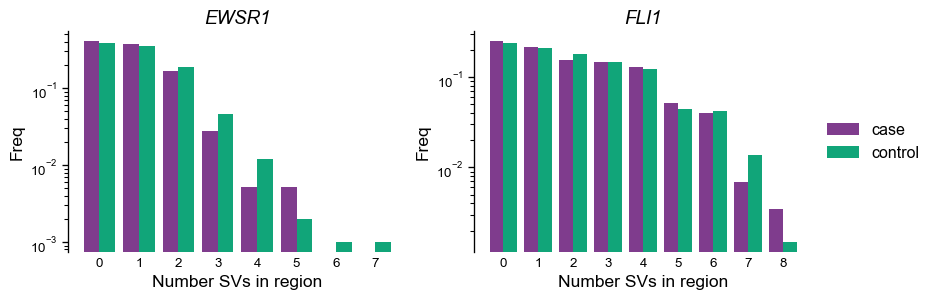

In [115]:
fig, axes = plt.subplots(1, len(gene_locs), figsize=(5 * len(gene_locs), 3))
for i, g in enumerate(gene_locs["gene"]):
    
    column = 'rare + common ' + g
    ax = axes[i]

    case_data = model_data.query("disease == 1")[column].value_counts()
    control_data = model_data.query("disease == 0")[column].value_counts()

    case_data = case_data / case_data.sum()
    control_data = control_data / control_data.sum()

    max_case = np.max(case_data.index)
    max_control = np.max(control_data.index)

    case_x = np.arange(0.3, max_case + 1.3, 1)
    control_x = np.arange(0.7, max_control + 1.7, 1)

    ax.bar(x=case_x, height=case_data, width=0.4, label="case")
    ax.bar(x=control_x, height=control_data, width=0.4, label="control")

    ax.set_yscale("log")
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    counts = np.arange(0, np.max([max_case, max_control]) + 1)
    ax.set_xticks(counts + 0.5)
    ax.set_xticklabels(counts)

    ax.set_xlabel("Number SVs in region")
    ax.set_ylabel("Freq")
    ax.set_title(g, fontstyle="italic")

axes[-1].legend(bbox_to_anchor=(1, 0.5))
fig.savefig('images/sv_burden.png')

So in fact in EWSR1 it looks like there's a small handful of controls that are different from cases.

## Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype.

In [116]:
columns = [
    "entity:sample_id",
    "disease",
    "median_coverage",
    "sex",
] + [col for col in metadata.columns if col.startswith("PC")]

model_data = metadata[
    metadata["entity:sample_id"].isin(ewings_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Now we add the genotypes to this model data.

In [117]:
sv_dosages = subsetted_gene_dosages.set_index("name")[ewings_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [118]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(ewings_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # statsmodels doesn

    # run the model
    try:
        endog = sv_model_data_nonna["disease"]
        exog = sm.tools.add_constant(sv_model_data_nonna[[sv] + columns[2:]])

        # suppress some failure warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = sm.Logit(
                endog=endog,
                exog=exog,
            ).fit(disp=0, method="bfgs", maxiter=1000)

        # store
        sv_models[sv] = model
        sv_results.append(
            [
                sv,
                model.pvalues[1],
                model.params[1],
                num_cases_dropped,
                num_controls_dropped,
            ]
        )

    except:
        sv_models[sv] = "fail"

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

In [119]:
sv_results.head(2)

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,
All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,0.790323,-0.345686,0,0
All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,0.719218,0.039840,0,0


Next we'll try plotting

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


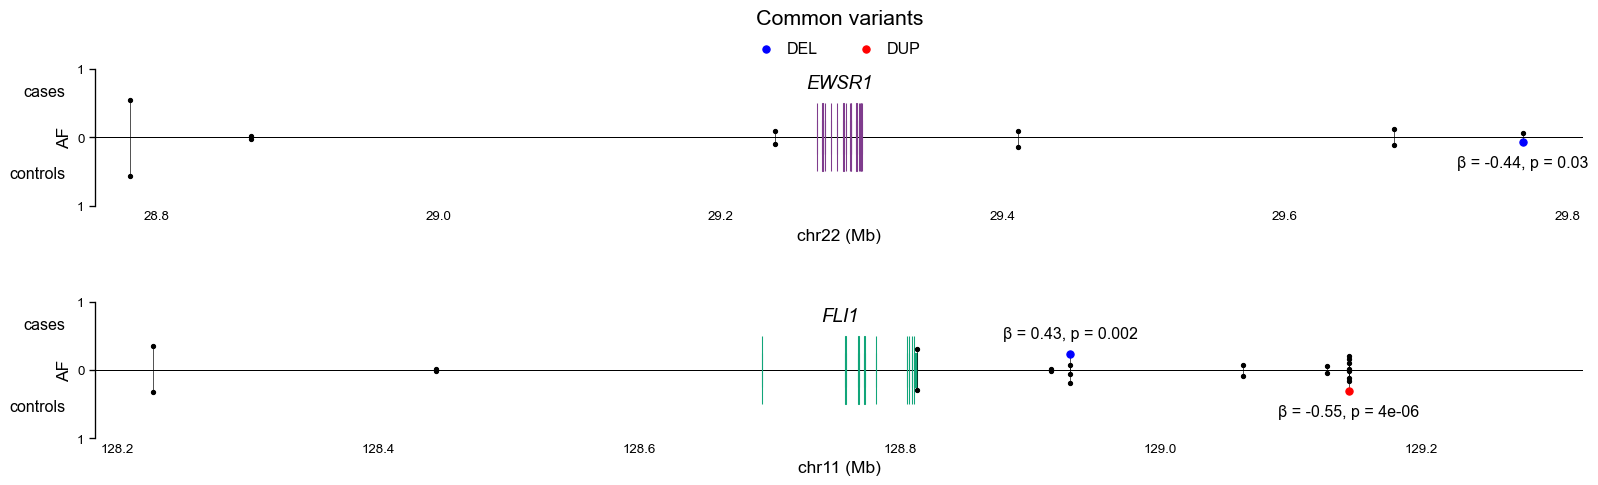

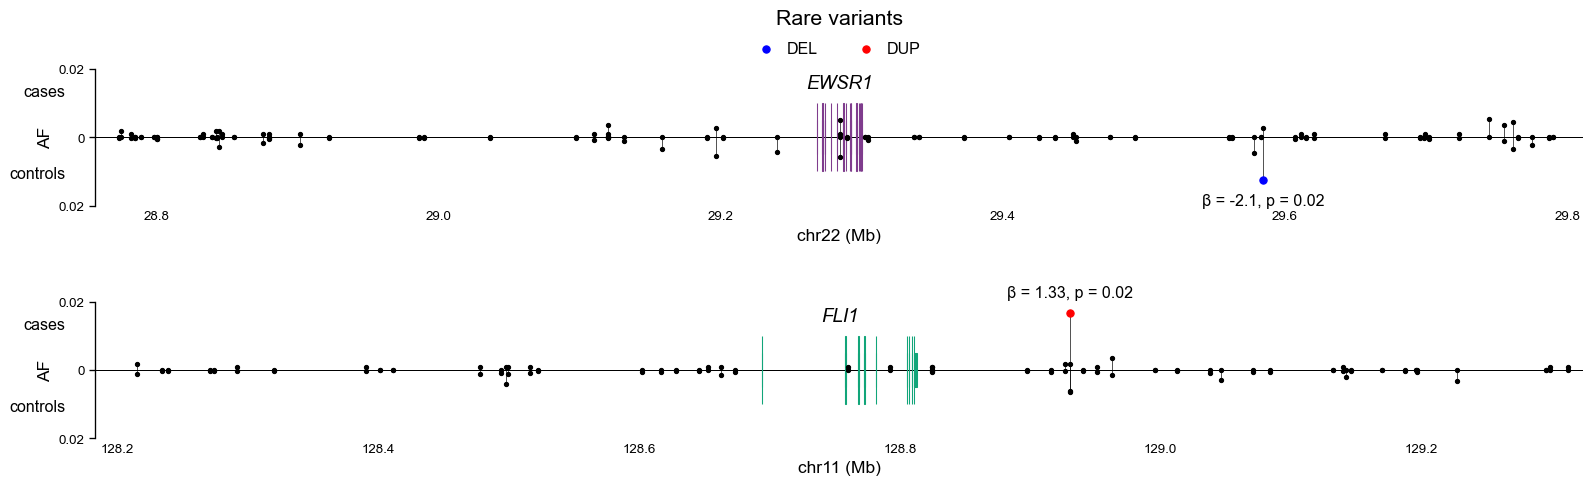

In [120]:
sv_colors = {"DEL": "blue", "DUP": "red"}

for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.7},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.80)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    legend_handles = {}
    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for j in range(len(gene_data)):
            loc = gene_data["midpoint"][j]
            name = gene_data["name"][j]

            case, control = case_y[j], control_y[j]

            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

            # look up the p value of the sv, if it exists
            if name in sv_results.index:
                p_val, coeff = sv_results.loc[name, ["p", "coeff"]]

                if p_val < 0.05:

                    y = case if coeff > 0 else -control
                    text_y = y + 0.3 if coeff > 0 else y - 0.3

                    sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                    color = sv_colors.get(sv_type)

                    scatter = ax.scatter(
                        [loc], [y], color=color, s=30, zorder=3, label=sv_type
                    )

                    if sv_type in ["DUP", "DEL"]:
                        legend_handles[sv_type] = scatter

                    # add text for coeff
                    if coeff < 3:
                        ax.text(
                            x=loc,
                            y=text_y,
                            s=f"β = {round(coeff, 2)}, p = {p_val:.1}",
                            ha="center",
                            va="center",
                        )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.3,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    axes[0].legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0.43, 1.15),
        ncol=2,
        handletextpad=0.3,
    )

    fig.savefig(f"images/{plot}.png")

### Some quick observations

I do want to make a quick note of at least two observations:

In [121]:
sv_results.query("p < 0.1")

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,
All_20_Batches.chr11.final_cleanup_DEL_chr11_6434,0.056415,0.824356,11,50
All_20_Batches.chr11.final_cleanup_DUP_chr11_2411,0.021760,1.329183,36,108
All_20_Batches.chr11.final_cleanup_DEL_chr11_6436,0.001901,0.425355,0,0
All_20_Batches.chr11.final_cleanup_INS_chr11_2666,0.070638,0.412401,51,175
All_20_Batches.chr11.final_cleanup_DUP_chr11_2415,0.000004,-0.551157,0,0
All_20_Batches.chr22.final_cleanup_DEL_chr22_1136,0.017938,-2.096533,0,0
All_20_Batches.chr22.final_cleanup_DEL_chr22_1144,0.061880,1.844155,0,0
All_20_Batches.chr22.final_cleanup_DEL_chr22_1146,0.027090,-0.441259,0,0
All_20_Batches.chr5.final_cleanup_CPX_chr5_79,0.041408,3.113124,0,0


In [122]:
len(ewings_samples), len(control_samples)

(580, 2019)

We can see that a handful of our hits dropped many samples from the model creation process, as they do not have the SV genotyped. There's roughly a 1:4 ratio of cases:controls, and from the list, we can see that we tend to drop more cases than controls (which makes sense, as they have lower coverage). I'm... not really sure how that effects things? I wonder if you can forcecall in those samples or something?

Oddly enough, we can also see that there's a complex SV that was called as significant, with a fairly high coefficient. Let's take a deeper look:

In [123]:
case_control_sv_counts.query('name == "All_20_Batches.chr5.final_cleanup_CPX_chr5_79"')

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
146,All_20_Batches.chr5.final_cleanup_CPX_chr5_79,EWSR1,chr5,31244571,31244572,0.000698,True,579,1,0,2017,2,0,31244571.5,0.000862,0.000495


That's... not particularly convincing. I'll have to ask Ryan and Riaz how they think about "significant" results with only 1 case.

# Examine pairwise analyses

Ryan had an interesting suggestion, which was to examine pairwise connections between EWSR1 and FLI1. The underlying logic is that perhaps there are SVs that predispose to rearrangement, and if they are present on both genes, they enhance the changes of rearrangement.

We're going to try lowering the rare SV threshold to 0.001, although this will yield many more false positives.

This shouldn't be that hard to do. We'll just construct the model dataset with all common SV pairs. Note that I'll also be running a fully joint model, i.e.

`disease ~ ewsr1 + fli1 + ewsr1:fli1 + covariates`

There's an open question of whether the interaction term should be binary or incorporate allele copy number (i.e. be 0, 1, 2, 4). I'm going to go with the latter for now, but it makes interpretation a bit harder.

## Deriving the odds ratios

A key component of this analysis will be accurately interpreting the interaction term. The interaction term is complicated--it does not exist on the same scale as the individual SV terms. To enhance interpretability, I'll calculate three odds-ratios:

1. The odds ratio of `ewsr1`. This represents the increase in odds when the sample has the EWSR1 sv.
2. The odds ratio of `fli1`. This represents the increase in odds when the sample has the FLI1 sv.
3. The odds ratio of _combined_ `ewsr1` and `fli1`, the increase in odds when the sample has both.

The last term is _not_ strictly governed by the interaction term - it represents the first two odds ratios combined AND includes the interaction terms. Models don't output this value--we need to calculate it ourselves. Following https://pubmed.ncbi.nlm.nih.gov/9789916/, we derive the following:

1. The odds ratio for the combined term is `exp(b1 + b2 + b3)`, where b1, b2, and b3 represent the coefficients of the individual SV terms (b1 and b2) and the interaction term (b3). This follows from the multiplicative nature of the logit model.
2. The confidence interval is much harder. The standard error of any coefficient in a GLM is given by `sqrt(var(coef))`, where `var(coef)` is given by the model's covariance matrix. But here we are dealing with a linear combination of coefficients (`b1 + b2 + b3`), so the variance is given by 

$$var(\beta_1 + \beta_2 + \beta_3) = var(β_1) + var(β_2) + var(β_3) + 2Cov(β_1, β_2) + 2Cov(β_1, β_3) + 2Cov(β_2, β_3)$$

The confidence interval is then the odds ratio +/- 1.96 * sqrt(var). We use the normal approximation (1.96 * SE) because we have a decently large number of samples.

To incorporate this into the model, we'll simply create a new row that refers to `combined`.

We can also calculate a p value fairly easily.

In [124]:
# given a statsmodel, return the coeff, SE, and confidence interval for the combined term
def derive_combined_params(model, var_1, var_2, var_int):
    """Given a models results, add a new row reflecting the combined term.
    var_1 and var_2 represent the names of individual terms, the int_var
    represents the name of the interaction variable.

    Expected input is a statsmodels model. Output is (coef, se, z, p)
    """

    # get model results and covariance matrix
    model_results = pd.read_html(
        joint_model.summary().tables[1].as_html(), header=0, index_col=0
    )[0]
    cov_mat = model.cov_params()

    # coef = b1 + b2 + b3
    coeff_combined = model_results.loc[[var_1, var_2, var_int], "coef"].sum()

    # calculate var(b1 + b2 + b3)
    var_combined = (
        cov_mat.loc[var_1, var_1]
        + cov_mat.loc[var_2, var_2]
        + cov_mat.loc[var_int, var_int]
        + 2 * cov_mat.loc[var_1, var_2]
        + 2 * cov_mat.loc[var_1, var_int]
        + 2 * cov_mat.loc[var_2, var_int]
    )
    se_combined = np.sqrt(var_combined)

    # calculate z value of x = 0 (for hypothesis testing)
    z = (coeff_combined - 0) / se_combined

    # calculate p value - two sided
    p = 2 * stats.norm.cdf(z)

    return coeff_combined, se_combined, z, p

## Actually calculate the joint models

In [ ]:
# drop the AF cutoff, just in case there's some really strong signal we miss
svs_to_keep_pairwise = subsetted_gene_dosages[["name", "gene", "AF"]].copy()
svs_to_keep_pairwise["rare"] = subsetted_gene_dosages["AF"] < 0.001

In [ ]:
ewsr1_common_svs = svs_to_keep_pairwise[
    (svs_to_keep_pairwise["gene"] == "EWSR1") & (~svs_to_keep_pairwise["rare"])
]["name"].to_list()
fli1_common_svs = svs_to_keep_pairwise[
    (svs_to_keep_pairwise["gene"] == "FLI1") & (~svs_to_keep_pairwise["rare"])
]["name"].to_list()

In [ ]:
len(fli1_common_svs) * len(ewsr1_common_svs)

We make combinations of these

In [ ]:
combinations = [(ewsr1, fli1) for ewsr1 in ewsr1_common_svs for fli1 in fli1_common_svs]

In [ ]:
columns = [
    "entity:sample_id",
    "disease",
    "median_coverage",
    "sex",
] + [col for col in metadata.columns if col.startswith("PC")]

model_samples = ewings_samples + control_samples
model_data = metadata[metadata["entity:sample_id"].isin(model_samples)][
    columns
].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Next we build our "dosage matrix", where a sample gets 1 if it has both SVs and 0 otherwise. This is going to get a bit complicated, as we run several models in one.

In [ ]:
joint_sv_models = {}
joint_sv_results = []

for combo in combinations:

    # extract which SVs are part of this combo
    ewsr1_sv, fli1_sv = combo
    joint_sv = "+".join(combo)

    # to store results
    df_row = []

    # get the gene dosages
    ewsr1_dosage = subsetted_gene_dosages.set_index("name").loc[ewsr1_sv, model_samples]
    fli1_dosage = subsetted_gene_dosages.set_index("name").loc[fli1_sv, model_samples]

    # extract single and joint dosages
    combo_dosage = ewsr1_dosage * fli1_dosage

    # fill in model data - single SVs and combos
    model_data.loc[ewsr1_dosage.index, ewsr1_sv] = ewsr1_dosage.astype(float)
    model_data.loc[fli1_dosage.index, fli1_sv] = fli1_dosage.astype(float)
    model_data.loc[combo_dosage.index, joint_sv] = combo_dosage.astype(float)

    # run the joint model
    endog = model_data["disease"]
    exog_joint = sm.tools.add_constant(
        model_data[[ewsr1_sv, fli1_sv, joint_sv] + columns[2:]]
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        joint_model = sm.Logit(endog=endog, exog=exog_joint, missing="drop").fit(
            disp=0, method="bfgs", maxiter=1000
        )

    joint_sv_models[joint_sv] = joint_model

    # fetch model results in df form
    model_results = pd.read_html(
        joint_model.summary().tables[1].as_html(), header=0, index_col=0
    )[0]

    # do some extensive reformatting
    model_results = model_results.iloc[1:4]
    model_results.index = ["ewsr1 joint", "fli1 joint", "interaction"]
    model_results = model_results.reset_index().rename(columns={"index": "component"})

    # add in the COMBINED results
    try:
        combined_coef, combined_se, z, p = derive_combined_params(
            joint_model, ewsr1_sv, fli1_sv, joint_sv
        )
        model_results.loc[3] = [
            "combined",
            combined_coef,
            combined_se,
            z,
            p,
            combined_coef - 1.96 * combined_se,
            combined_coef + 1.96 * combined_se,
        ]

    # will fail if model did not fit
    except:
        model_results.loc[3] = ["combined"] + [np.nan] * 6

    # add in the single model results
    for gene, sv in zip(["ewsr1", "fli1"], [ewsr1_sv, fli1_sv]):

        # get model
        single_gene_model = sv_models[sv].summary().tables[1]
        single_gene_results = pd.read_html(
            single_gene_model.as_html(), header=0, index_col=0
        )[0].iloc[1]
        single_gene_results.loc["component"] = f"{gene} single"
        model_results = model_results.append(single_gene_results)

    model_results.insert(0, "joint_sv", ewsr1_sv + "+" + fli1_sv)
    model_results = model_results.reset_index(drop=True)

    joint_sv_results.append(model_results)

joint_sv_results = pd.concat(joint_sv_results).reset_index(drop=True)
joint_sv_results.columns = [
    "joint_sv",
    "component",
    "coef",
    "se",
    "z",
    "p",
    "[0.025",
    "0.975]",
]

We can add in odds ratio data here as well. Note that the odds ratio metric for the interaction term is meaningless (or rather, in the incorrect scale), so we reset those.

In [ ]:
joint_sv_results["odds_ratio"] = np.exp(joint_sv_results["coef"])
joint_sv_results["odds_ratio_[0.025"] = np.exp(joint_sv_results["[0.025"])
joint_sv_results["odds_ratio_0.975]"] = np.exp(joint_sv_results["0.975]"])

# find and reset the interaction terms
interaction_indices = np.where(joint_sv_results["component"] == "interaction")[0]
joint_sv_results.loc[
    interaction_indices, ["odds_ratio", "odds_ratio_[0.025", "odds_ratio_0.975]"]
] = np.nan

In [ ]:
joint_sv_results = joint_sv_results.set_index("joint_sv")

In [ ]:
joint_sv_results.head(6)

In [ ]:
joint_sv_results.query('component == "interaction" & p < 0.05')

Interesting... some of these are definitely plausible. Let's check one in particular:

In [ ]:
joint_sv_results.loc[
    "All_20_Batches.chr22.final_cleanup_DEL_chr22_1146+All_20_Batches.chr11.final_cleanup_DEL_chr11_6407"
]

So in this instance, EWSR1 is pretty clearly carrying the main signal, but there is a significant interaction term.

Are there any SV pairs where the combo is significant when neither gene is alone?

In [ ]:
ewsr1_sig = joint_sv_results.query('component == "ewsr1 joint"')["p"] > 0.05
fli1_sig = joint_sv_results.query('component == "fli1 joint"')["p"] > 0.05

ewsr1_sig = ewsr1_sig.index[np.where(ewsr1_sig)[0]]
fli1_sig = fli1_sig.index[np.where(fli1_sig)[0]]

nonsig_single_svs = set(ewsr1_sig) & set(fli1_sig)

potential_synergies = joint_sv_results.loc[nonsig_single_svs][
    lambda row: (row["component"] == "interaction") & (row["p"] < 0.05)
]

potential_synergies

So three potential SVs here. It's not obvious to me that these are the only ones we want, but they certainly are interesting.

What about SVs where the interaction term AND combined odds ratio is significant?

In [ ]:
interaction_sig = joint_sv_results.query('component == "interaction"')["p"] < 0.05
combined_sig = joint_sv_results.query('component == "combined"')["p"] < 0.05

interaction_sig = interaction_sig.index[np.where(interaction_sig)[0]]
combined_sig = combined_sig.index[np.where(combined_sig)[0]]

sig_indices = set(interaction_sig) & set(combined_sig)

potential_synergies = joint_sv_results.loc[interaction_sig].query('component == "combined"')

potential_synergies

### Following up with some plots

There are a _ton_ of variants to cover here, ad they're not all easy to interpret. I think the most convincing evidence, if it exists, will be just straight up allele fraction or odds ratio plots. We'll make both for any result with a significant p value. By definition, this includes an enormous number of false positives.

In [ ]:
significant_results = joint_sv_results.query("p < 0.05")
significant_joint_svs = sorted(set(significant_results.index))

In [ ]:
len(significant_joint_svs)

In [ ]:
for joint_sv in significant_joint_svs:
    ewsr1_sv, fli1_sv = joint_sv.split("+")

    fig = plt.figure(figsize=(13, 3))

    # make the overall gridspec - divides gene body from coverage
    overall_gs = fig.add_gridspec(1, 2, wspace=0.3, width_ratios=[8, 5])
    gene_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=overall_gs[0], hspace=0.6)

    joint_sv_params = joint_sv_results.loc[joint_sv].reset_index().set_index("component")
    joint_sv_params = joint_sv_params.loc[
        [
            "ewsr1 single",
            "fli1 single",
            "ewsr1 joint",
            "fli1 joint",
            "interaction",
            "combined",
        ]
    ]

    ax = fig.add_subplot(overall_gs[1])

    # plot the points and confidence intervals
    loc = 0
    for index, row in joint_sv_params.iterrows():

        # interactions aren't plotted
        if index == "interaction":
            continue

        # odds ratio and confidence interval
        if not np.isnan(row["[0.025"]):
            ax.scatter([loc], [row["coef"]], color="black")
            
            if row['[0.025'] < -10 or row["0.975]"] > 10:
                bottom, top = -10, 10
            else:
                bottom, top = row['[0.025'], row["0.975]"]

            ax.plot([loc, loc], [bottom, top], color="black")

        p = row["p"]
        if p < 0.05:
            p_formatted = f"p = {p:.1g}"
            y = row["0.975]"]

            ax.text(s=p_formatted, x=loc, y=y + 0.1, ha="center", va="bottom", fontsize=10)

        if index != "fli1 single":
            loc += 1
        else:
            loc += 1.5

    ax.axhline(y=0, color="darkgrey", linestyle="dashed", zorder=0)
    aesthetics.strip_axis(ax, y="ignore", x="label")
    ax.set_xticks([0.5, 3.5])

    # if the interaction term is significant, add it to the plot
    xlabels = ["Single model", "Joint model"]
    p_int = joint_sv_params.loc["interaction", "p"]
    if p_int < 0.05:
        p_formatted = f"p = {p_int:.1g}"
        beta = joint_sv_params.loc["interaction", "coef"]
        beta_formatted = f"β = {round(beta, 2)}"
        xlabels[1] = f"Joint model\n({p_formatted}, {beta_formatted})"

    ax.set_xticklabels(xlabels)
    ax.tick_params(axis="x", pad=20, labelsize=12)

    y_bottom = ax.get_ylim()[0]
    for loc, label in zip(
        [0, 1, 2.5, 3.5, 4.5], ["EWSR1", "FLI1", "EWSR1", "FLI1", "Combined"]
    ):
        fontstyle = "italic" if label != "Combined" else None
        ax.text(
            s=label,
            x=loc,
            y=y_bottom,
            ha="center",
            va="top",
            fontstyle=fontstyle,
            fontsize=10,
        )
    ax.set_xlim([-0.5, 5])
    ax.set_ylabel("Normalized\nlog odds ratio")

    # next, we add the genes for visualization purposes.
    axes = []
    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = fig.add_subplot(gene_gs[i])
        axes.append(ax)

        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.80, fontsize=12)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(expanded_gene_locs.loc[g, ["start", "end"]].values)

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right", fontsize=8)
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right", fontsize=8)

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)", fontsize=10)

    # add the data for the SVs in question
    for i, (gene, sv) in enumerate(zip(['EWSR1', 'FLI1'], [ewsr1_sv, fli1_sv])):
        sv_data = case_control_sv_counts.set_index('name').loc[sv]

        x = sv_data['midpoint']
        y = sv_data[['AF_cases', 'AF_controls']]

        max_freq = y.max() * 2
        rounded_max = min(1, math.ceil(max_freq * 100) / 100)

        y = y / rounded_max

        # add points
        axes[i].scatter([x, x], [y[0], -y[1]], color = 'black')
        axes[i].plot([x, x], [y[0], -y[1]], color = 'black')

        axes[i].set_yticklabels([rounded_max, 0, rounded_max])
        axes[i].set_ylabel("AF", fontsize=10)

    sv_types = svs_to_keep.set_index('name').loc[[ewsr1_sv, fli1_sv], 'svtype'].values.astype(str)
    title = f"EWSR1 = {ewsr1_sv} ({sv_types[0]})\nFLI1 = {fli1_sv} ({sv_types[1]})"
    fig.suptitle(title, fontsize=14, y = 1.1)
    
    fig.savefig(f'images/joint_sv_plots/{joint_sv}.png')
    
    plt.close(fig)

## Plot all SVs

We'll be plotting all SVs and connecting the ones that are significant.

In [ ]:
sv_colors = {
    "DEL": "blue",
    "DUP": "red",
    "INS:ME:ALU": bold_10[0],
    "INS:ME:LINE1": bold_10[1],
}

In [ ]:
fig, axes = plt.subplots(
    len(expanded_gene_locs),
    1,
    figsize=(20, 2.5 * len(expanded_gene_locs)),
    gridspec_kw={"hspace": 0.7},
)

for i, g in enumerate(expanded_gene_locs["gene"]):

    ax = axes[i]
    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
    window = expanded_gene_locs.loc[g, ["start", "end"]].values
    feature_span = {"exon": 0.25, "CDS": 0.5}

    ax = sv_plot.plot_genomic_elements(
        ax,
        g_gtf,
        window=window,
        feature_span=feature_span,
        feature_colors=feature_colors,
        label=False,
    )
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    contig = expanded_gene_locs.loc[g, "chrom"]
    ax.set_title(g, fontstyle="italic", y=0.80)

    # plot the range of interest
    ax.set_xlim(
        expanded_gene_locs.loc[g, ["start", "end"]].values + np.array([-10000, 10000])
    )
    ax.spines["bottom"].set_bounds(expanded_gene_locs.loc[g, ["start", "end"]].values)

    # add labels
    ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
    ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

    # switch to Mb
    ax.set_xticklabels(ax.get_xticks() / 1e6)
    ax.set_xlabel(f"{contig} (Mb)")

# next we add in the SVs. First subset to the SVs in question
plot_svs = case_control_sv_counts.query("AF > 0.001")

legend_handles = {}
sv_locations = {"EWSR1": {}, "FLI1": {}}
for i, gene in enumerate(expanded_gene_locs["gene"]):

    ax = axes[i]
    gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

    # get the max frequency
    max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()
    rounded_max = math.ceil(max_freq * 100 + 3) / 100

    # its much easier to plot everything at once with plt.stem, but that function sucks
    # we scale the frequency to fill the plot
    case_y = (gene_data["AF_cases"]) / rounded_max
    control_y = (gene_data["AF_controls"]) / rounded_max

    # add the points
    ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
    ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

    # add the lollipop lines
    for j in range(len(gene_data)):
        loc = gene_data["midpoint"][j]
        name = gene_data["name"][j]

        case, control = case_y[j], control_y[j]

        ax.plot(
            [loc, loc],
            [case, -control],
            color="black",
            linewidth=0.5,
            zorder=3,
        )

        # store the results
        storage = [loc, -control] if gene == "EWSR1" else [loc, case]
        sv_locations[gene][name] = storage

        # look up the p value of the single model sv, if it exists
        if name in sv_results.index:
            p_val, coeff = sv_results.loc[name, ["p", "coeff"]]

            if p_val < 0.05:

                y = case if coeff > 0 else -control
                text_y = y + 0.3 if coeff > 0 else y - 0.3

                sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                color = sv_colors.get(sv_type)

                scatter = ax.scatter(
                    [loc], [y], color=color, s=30, zorder=4, label=sv_type
                )
                legend_handles[sv_type] = scatter

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([rounded_max, 0, rounded_max])
    ax.set_ylabel("AF")

# add a title - can't use suptitle because that doesn't center over the gene
axes[0].text(
    s=plot.capitalize() + " variants",
    x=0.5,
    y=1.3,
    transform=axes[0].transAxes,
    ha="center",
    va="bottom",
    fontsize=16,
)

axes[0].legend(
    handles=legend_handles.values(),
    labels=legend_handles.keys(),
    bbox_to_anchor=(0.43, 1.15),
    ncol=2,
    handletextpad=0.3,
)

# connect using joint SV model
for ewsr1_sv, fli1_sv in combinations:
    joint_sv = ewsr1_sv + "+" + fli1_sv
    joint_sv_res = joint_sv_results.loc[joint_sv]

    int_p, combined_p = joint_sv_res.set_index("component").loc[
        ["interaction", "combined"], "p"
    ]

    # get the coordinates
    ewsr1_coord = sv_locations["EWSR1"][ewsr1_sv]
    fli1_coord = sv_locations["FLI1"][fli1_sv]

    ewsr1_fig = fig.transFigure.inverted().transform(
        axes[0].transData.transform(ewsr1_coord)
    )
    fli1_fig = fig.transFigure.inverted().transform(
        axes[1].transData.transform(fli1_coord)
    )

    fig_x = [ewsr1_fig[0], fli1_fig[0]]
    fig_y = [ewsr1_fig[1], fli1_fig[1]]

    linestyles = ["dotted", None]
    for i, p in enumerate([int_p, combined_p]):
        if p < 0.05:
            fig.add_artist(
                Line2D(
                    fig_x,
                    fig_y,
                    color="darkgrey",
                    linestyle=linestyles[i],
                    zorder=1,
                    linewidth=1,
                )
            )
            
fig.savefig('images/joint-sv-model-results.png')

# The unique case of MCNVs

Ryan and Riaz have pointed out that the above filtering approach will have removed all the MCNVs. These are worth taking a look at in detail, which we'll do now.

__Edit:__

It turns out there are no CNVs in this region... at all. Interesting.